<a href="https://colab.research.google.com/github/RoseSarlake/Computer-Vision/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import glob

In [4]:
# need a opencv version which has SIFT and SURF
# pip uninstall opencv-python
# pip install opencv-contrib-python==4.4.0.40
# pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17
cv2.__version__

'4.4.0'

Some useful function from assignment 1

In [5]:
def My_Gaussian(size,sigma):
  w = size 
  hw = (w-1)/2
  sum = 0
  g = np.zeros(w)
  for i in range(0,w):
    # The continuous normalization factor can be ignored since it disappears in the discrete normalization step
    g[i] = math.exp(-((i-hw)*(i-hw))/(2*sigma*sigma))
    sum += g[i]
  for i in range(0,w):
    g[i] /= sum
  return g

In [6]:
def My_convolve2D(image, kernel, padding=0):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1)
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply mirror padding
    if padding != 0:
        imagePadded = cv2.copyMakeBorder(image,padding,padding,padding,padding,cv2.BORDER_REFLECT)
        #print(imagePadded)
    else:
        imagePadded = image

    # Convolution
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
          output[x, y] = (kernel * imagePadded[x:x+xKernShape,y:y+yKernShape]).sum()
    return output

In [7]:
def My_sampling(img,n,way):
  #re_img = cv2.resize(img,(img2a.shape[1],img2a.shape[0]),fx=2**n,fy=2**n,interpolation = cv2.INTER_CUBIC)
  if way == "up":
    re_img = cv2.resize(img,None,fx=2**n,fy=2**n,interpolation = cv2.INTER_CUBIC)
  if way == "down":
    re_img = cv2.resize(img,None,fx=1/2**n,fy=1/2**n,interpolation = cv2.INTER_CUBIC)
  return re_img

In [8]:
def My_pyrm(img,time,way):
  imgset = [img]
  sigma = 1
  for i in range(0,time):

    new = My_sampling(img,i+1,way)

    col = My_Gaussian(5,sigma)
    row = col.reshape(col.shape[0],1)
    ker = col*row
    conimg = My_convolve2D(new,ker,padding=2)
    
    imgset.append(conimg)
  return imgset

In [9]:
def My_Lappyr(img,layer):
  # Create a Gaussian Pyramid
  my_g_pyr = My_pyrm(img,layer,"down")
  # Create a Laplacian Pyramid
  laplacian_pyr = [my_g_pyr[-1]]
  for i in range(layer,0,-1):
    expand = My_pyrm(my_g_pyr[i],1,"up")
    laplacian = my_g_pyr[i-1] - expand[1]
    laplacian_pyr.append(laplacian)
  return laplacian_pyr,expand

# pre-process image mosaic 

In [89]:
# locate to images path
path = glob.glob("/content/drive/MyDrive/Colab Notebooks/image/*.jpg")
# store images in a list
images = [cv2.imread(file) for file in path]
len(images)
# create a grayscale version to detect more accurate
workingset = images.copy()
for i in range(len(workingset)):
  workingset[i] = cv2.cvtColor(workingset[i], cv2.COLOR_BGR2GRAY)

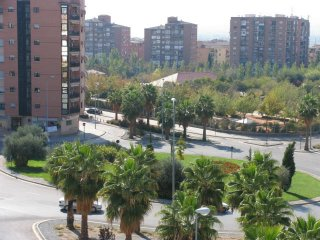

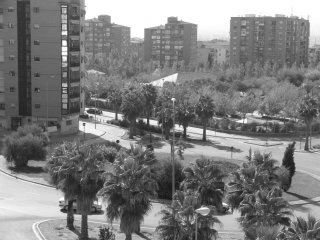

In [90]:
cv2_imshow(images[0])
cv2_imshow(workingset[0])

# Extract features 

In [97]:
def MyFeature(inputlist):
  # keypoints and descriptions in each images
  kp = [None] * len(inputlist)
  des = [None] * len(inputlist)
  sift = cv2.SIFT_create()

  for i in range(len(inputlist)):
    # create sift object
    # sift = cv2.SIFT_create()
    kp[i], des[i] = sift.detectAndCompute(inputlist[i],None)
  return kp,des

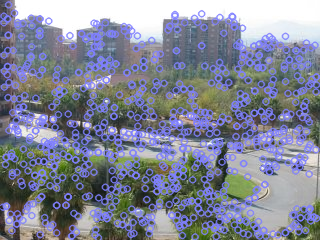

In [110]:
# detect and compute the feature of all the image set
mypoints, mydes = MyFeature(workingset)
# draw the keypoints
cv2_imshow(cv2.drawKeypoints(images[1],mypoints[1],None,(300,128,128)))

# Match features


In [103]:
def MyMatching(des):
  # Create a BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  # store the matching points, the length is 1 less than description list
  matches = [None] * (len(des)-1)
  # find matching points
  for i in range(len(des)-1):
    # find matching points
    matches[i] = bf.match(des[i],des[i+1])
    # sort the keypoint by the distance
    matches[i] = sorted(matches[i], key = lambda x:x.distance)
  return matches

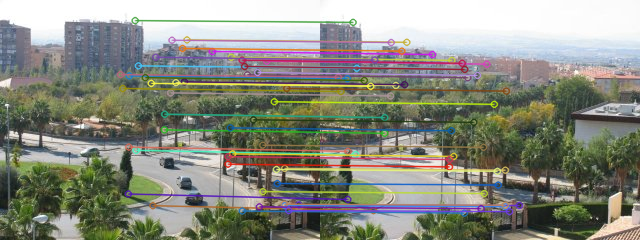

In [111]:
# compute all the matching pairs between every two neighboring images
mymatches = MyMatching(mydes)
# show one matching result, show the most strong 50 pairs
matching = cv2.drawMatches(images[4],mypoints[4],images[5],mypoints[5],mymatches[4][:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(matching)

In [93]:
# create a matrix to store matching point pairs 
p1 = np.zeros((len(matches), 2))
p2 = np.zeros((len(matches), 2))
for i in range(len(matches)):
  p1[i, :] = kp1[matches[i].queryIdx].pt
  p2[i, :] = kp2[matches[i].trainIdx].pt

# Compute a homography using RANSAC

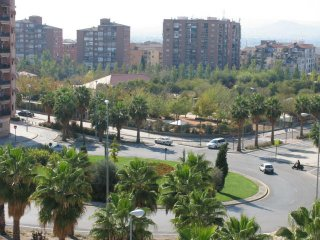

In [17]:
# compute the homography 
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
transformed_img = cv2.warpPerspective(images[0], homography, (images[1].shape[1], images[1].shape[0]))
transformed_img[0:images[1].shape[0], 0:images[1].shape[1]] = images[1]
cv2_imshow(transformed_img)

In [18]:
images[1].shape[0]


240

In [19]:
width = images[0].shape[1] + images[1].shape[1]
height = images[0].shape[0] + images[1].shape[0]
height, width = img2.shape
result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

NameError: ignored

# Align images

Define a big canvas

In [92]:
def My_convColor(image, kernel, padding=0):
  blue = My_convolve2D(A[:,:,0], kernel, padding)
  green = My_convolve2D(A[:,:,1], kernel, padding)
  red = My_convolve2D(A[:,:,2], kernel, padding)
  merged = cv2.merge([blue, green, red])
  return merged

In [157]:
import cv2
import numpy as np,sys
import sys

A = cv2.imread("/content/drive/MyDrive/Colab Notebooks/image/mosaico002.jpg")
B = cv2.imread("/content/drive/MyDrive/Colab Notebooks/image/mosaico006.jpg")
blueA = A[:,:,0]
greenA = A[:,:,1]
redA = A[:,:,2]
blueB = B[:,:,0]
greenB = B[:,:,1]
redB = B[:,:,2]

gpA_blue = My_pyrm(blueA,4,"down")
gpB_blue = My_pyrm(blueB,4,"down")
[lpA_blue,expA_blue] = My_Lappyr(blueA,4)
[lpB_blue,expB_blue] = My_Lappyr(blueB,4)

# LS = []
# for la,lb in zip(lpA,lpB):
#     rows,cols,dpt = la.shape
#     ls = np.hstack((la[:,0:cols/2], lb[:,cols/2:]))
#     LS.append(ls)

# # now reconstruct
# ls_ = LS[0]
# for i in range(1,6):
#     ls_ = cv2.pyrUp(ls_)
#     ls_ = cv2.add(ls_, LS[i])

# # image with direct connecting each half
# real = np.hstack((A[:,:cols/2],B[:,cols/2:]))

# cv2_imshow(ls_)
# cv2_imshow(real)

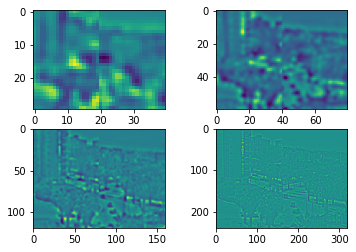

In [177]:
LS = []
for la,lb in zip(lpA_blue,lpB_blue):
    rows,cols = la.shape
    ls = np.hstack((la[:,0:int(cols/2)], lb[:,int(cols/2):]))
    LS.append(ls)

for i in range (1,len(LS)):
    plt.subplot(2,2,i)
    plt.imshow(LS[i])

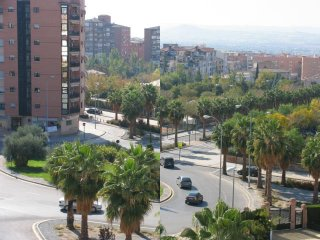

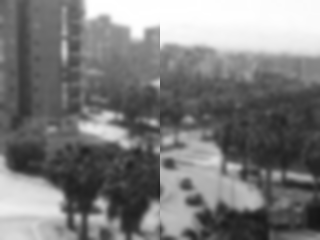

In [195]:
real = np.hstack((A[:,:int(cols/2)],B[:,int(cols/2):]))
cv2_imshow(real)
dir = np.hstack((A_blue[1][:,:int(cols/2)],B_blue[1][:,int(cols/2):]))
cv2_imshow(dir)

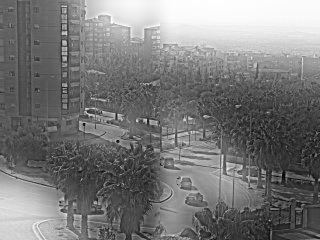

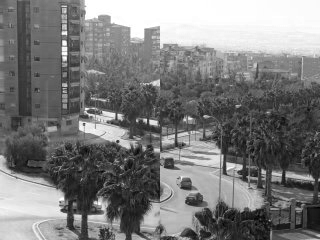

In [210]:
# now reconstruct
ls_ = LS[0]

rec = My_pyrm(LS[0],4,"up")
    #ls_ = cv2.pyrUp(ls_)
recover1 = LS[4]+rec[4]
cv2_imshow(recover1)
dir = np.hstack((blueA[:,:int(cols/2)],blueB[:,int(cols/2):]))
cv2_imshow(dir)

In [211]:
len(rec)

5

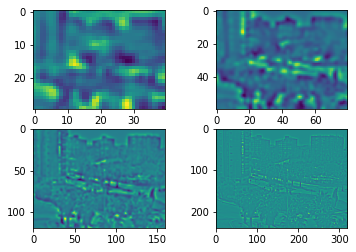

In [161]:
for i in range (1,len(lpA_blue)):
    plt.subplot(2,2,i)
    plt.imshow(lpA_blue[i])